# Common raster operations

When working with raster data, there are various operations and techniques that might be useful when preprocessing the data for further analysis. Some typical raster operations include for example selecting, clipping or masking raster to include only pixels that are located in a given area or at given indices, merging multiple raster tiles into a single raster mosaic, converting raster data into vector format (and vice versa), or resampling the raster pixels into higher or lower spatial resolution (upscaling, downscaling). In this chapter, we will learn how to conduct these kind of raster operations using `xarray`, `rioxarray`, `geocube` and `rasterio` Python libraries.

## Selecting data

Being able to select data based on indices or certain criteria (e.g. all values above specific threshold) is one of the most common operations that you need to do when working with any kind of data (raster, vector, as well as non-geographical data). When working with raster data, we can take advantage of `xarray`'s flexible indexing routines that combine the best features of `numpy` and `pandas` for data selection.

There are various ways how you can select data from `DataArray` and `Dataset`, but some of the most commonly used methods include `.isel()`, `.sel()` and `.where()` which we will introduce in the following. Let's start by reading the `elevation` dataset that we used earlier in Chapter 7.2:

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

fp = "data/temp/kilimanjaro_dataset.nc"

data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 156MB
Dimensions:          (y: 3601, x: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int32 4B ...
Data variables:
    elevation        (y, x) float64 104MB ...
    relative_height  (y, x) float32 52MB ...

Let's also plot the data to see how our values and coordinates (x and y) distribute over a map:

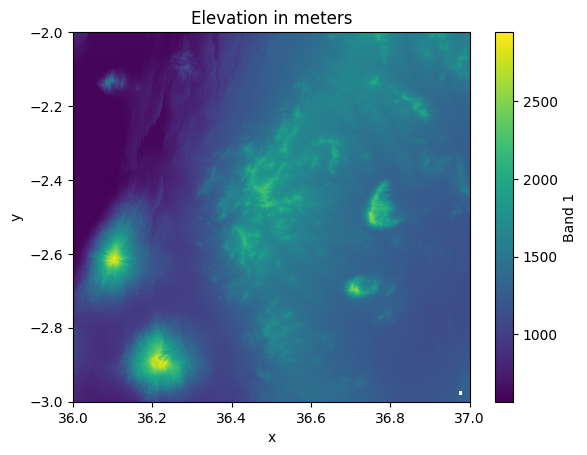

In [3]:
data["elevation"].plot()
plt.title("Elevation in meters");

_**Figure 7.7.** Elevation of the landscape in North-Eastern Tanzania._

### Selecting data by index values

The logic for selecting data from a `DataArray` values works quite similarly as we have learned earlier in this book using `pandas` (for `Series` and `DataFrame` objects), except that the returned object in `xarray` is always another `DataArray`. To select data based on specific index values, we can take advantage of the `.isel()` method that can be used similarly with `Dataset` and `DataArray` objects. For instance, we might be interested to select a cell at index `[0, 0]` in the array which corresponds to the cell that is located at the very top-left corner of the raster. To do this, we specify that the index value for both `x` and `y` dimension is `0` when calling the `.isel()` method:

In [20]:
selected_cell = data.isel(x=0, y=0)
selected_cell

<xarray.Dataset> Size: 32B
Dimensions:          ()
Coordinates:
    x                float64 8B 36.0
    y                float64 8B -2.0
    spatial_ref      int32 4B ...
Data variables:
    elevation        float64 8B ...
    relative_height  float32 4B ...

As we can see, the output is always returned as an `xarray` object, which in our case is a `Dataset`. To access the `elevation` or `relative_height` value at this given position, we can use the `.item()` which will return the value as a regular number (as learned in Chapter 7.2):

In [32]:
selected_cell["elevation"].item()

826.0

In [33]:
selected_cell["relative_height"].item()

258.0

Quite often when working with raster data, you are interested to select a range of values from a given raster (called slicing). To slice the data based on index ranges, we can use the same `.isel()` method and provide the information about the index range using the Python's built-in `slice()` function that can be used to specify a range of indices to be included in the selection by specifying `start` and `end` index positions. In the following, we will select the first 1000 cells in the x and y dimensions: 

In [39]:
selection = data.isel(x=slice(0, 1000), y=slice(0,1000))
selection

<xarray.Dataset> Size: 12MB
Dimensions:          (y: 1000, x: 1000)
Coordinates:
  * x                (x) float64 8kB 36.0 36.0 36.0 36.0 ... 36.28 36.28 36.28
  * y                (y) float64 8kB -2.0 -2.0 -2.001 ... -2.277 -2.277 -2.277
    spatial_ref      int32 4B ...
Data variables:
    elevation        (y, x) float64 8MB ...
    relative_height  (y, x) float32 4MB ...

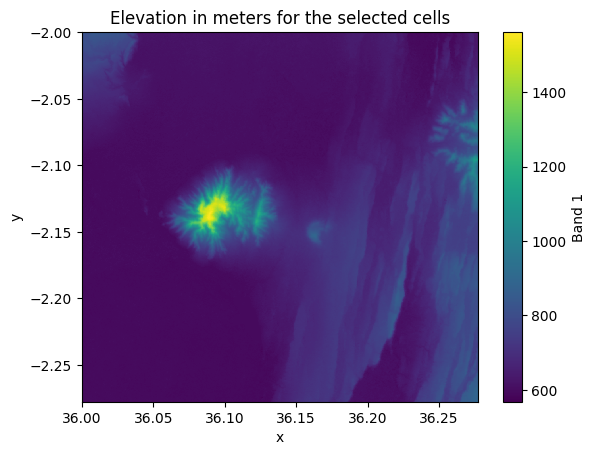

In [40]:
selection["elevation"].plot()
plt.title("Elevation in meters for the selected cells");

_**Figure 7.8.** Elevation values in the cells that were selected based on indices._

As we can see, now the shape of our output `Dataset` is 1000x1000 cells and the selection covers to top-left corner of our input `Dataset`. 

### Selecting data based on coordinates

While selecting data based on index positions might be useful in certain situations, quite often you want to select data based on coordinates. To do this, we can take advantage of the coordinate labels using `.sel()` method, which allows for more intuitive selection by providing the actual coordinates for you area of interest. Next, we will do the selection for an area that covers the following area: 
- x-coordinates: `36.4` - `36.6`
- y-coordinates: `-2.4` - `-2.6`

In [46]:
area_of_interest = data.sel(x=slice(36.4, 36.6), y=slice(-2.4, -2.6))

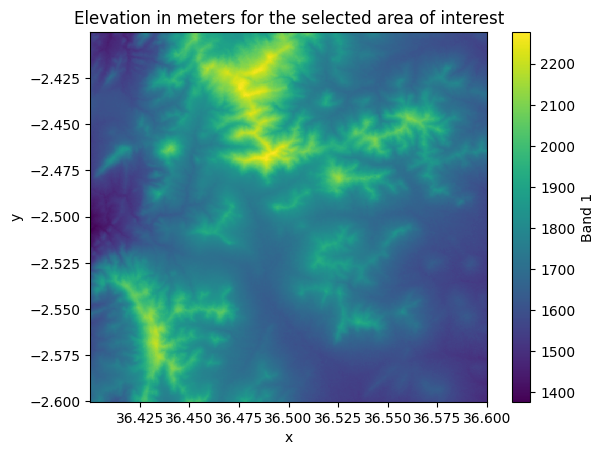

In [47]:
area_of_interest["elevation"].plot()
plt.title("Elevation in meters for the selected area of interest");

_**Figure 7.9.** Elevation values in the cells that were selected based on coordinates._

Nice! Now we have selected the data for a given area of interest that we specified using the coordinates. In a similar manner, you can select data for any specific area of interest. Couple of important things to remember when selecting data based on coordinates: 1) The coordinate values provided for the selection need to be within the extent of a given input raster dataset. 2) The coordinates provided for the selection need to be in the same coordinate reference system (CRS) as the input raster. For example, here we provided the coordinates as Decimal Degrees because our input data contains coordinates as latitudes and longitudes. However, if your coordinates are represented e.g. in a metric coordinate reference system (e.g. UTM), then your selection should be based on coordinates in a metric system. 

### Selecting data based on logical conditions

A third way to select data from a given raster is based on a specific criteria. To select data based on specific conditions, we can use the `.where()` method which is a handy tool to make conditional selections. For instance, we might be interested to select only such pixels from the raster where the elevation is above 2000 meters:

In [55]:
moderate_altitudes = data.where(data["elevation"] > 2000)

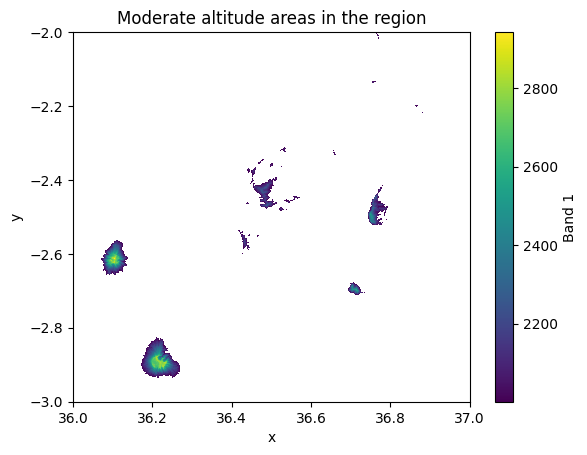

In [56]:
moderate_altitudes["elevation"].plot()
plt.title("Moderate altitude areas in the region");

_**Figure 7.10.** Elevation values in the cells that were above a specific criteria (2000 meters)._

As a result, we now have a map that highlights the areas where the elevation is above 2 kilometers. In a similar manner, we can also combine multiple conditions to a single selection. In the following, we will select all pixels where the elevation is above 1000 meters and below or equal to 1500 meters:

In [57]:
condition = (data["elevation"] > 1000) & (data["elevation"] <= 1500)
low_altitudes = data.where(condition)

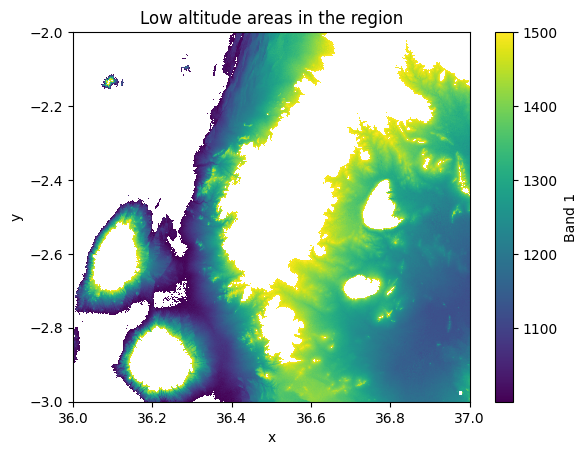

In [58]:
low_altitudes["elevation"].plot()
plt.title("Low altitude areas in the region");

_**Figure 7.11.** Elevation values in the cells that are between 1000-1500 meters._

Excellent, now we have a map that highlights the elevations between specific elevation range. In a similar manner, you can conduct selections by combining selection criteria over a single data variable or even combine conditions over multiple different variables. 

## Clipping raster

In the previous section we learned how to select data based on given criteria or by specifying an area of interest based on coordinates. However, quite often you actually have another geographic dataset that should be used to crop or select the data for your analysis. Clipping is one of the common raster operations in which you clip a given raster `Dataset` by another layer. This process allows you to crop the data in a way that only the cells that are e.g. within a given Polygon are selected for further analysis. In the following, we will learn how to do this by using the `.rio.clip()` method that comes with the `rioxarray` library. 

To be able to clip this `xarray.Dataset`, we first need to create a `geopandas.GeoDataFrame` that contains the geometry that we want to use as our clipping features. In our case, we want to create a simple bounding box that defines the area which we want to keep from the raster. To create the `GeoDataFrame`, we can specify the corner coordinates of our bounding box and utilize the `box` function of `shapely` library which can conveniently create us the geometry (as introduced in Chapter 6.1):

In [3]:
import geopandas as gpd
from shapely.geometry import box

# Bounding box coordinates
minx = 36.1
miny = -3
maxx = 36.3
maxy = -2.77

# Create a GeoDataFrame that will be used to clip the raster
bbox_geometry = box(minx, miny, maxx, maxy)
clipping_gdf = gpd.GeoDataFrame(geometry=[bbox_geometry], crs="epsg:4326")

# Explore the extent on a map
clipping_gdf.explore()

_**Figure 7.11.** Our area of interest around the Mt Kitumbene in Tanzania which will be used to clip the raster dataset._

Now after we have created the `GeoDataFrame` we can use it to clip the `xarray.Dataset`. To do this, we use the `.rio.clip()` method which wants as input the `geometries` that will be used for clipping the raster data. We can pass the `gpd.GeoSeries` as an input for this (i.e. the `geometry` column of our `GeoDataFrame`) and we also specify the `crs` to be the same as in out input raster data. It is important that the coordinate reference system of both layers are the same whenever doing GIS operations between multiple layers. Thus, we use a simple `assert` to check the match before doing the clipping:

In [4]:
# Check that the CRS matches between layers (only continues if True)
assert clipping_gdf.crs == data.elevation.rio.crs

# Clip the raster
kitumbene = data.rio.clip(geometries=clipping_gdf.geometry, crs=data.elevation.rio.crs)

Perfect! Now we have succesfully clipped the raster with our bounding box. Let's make a map out of our results to see how our data looks like:

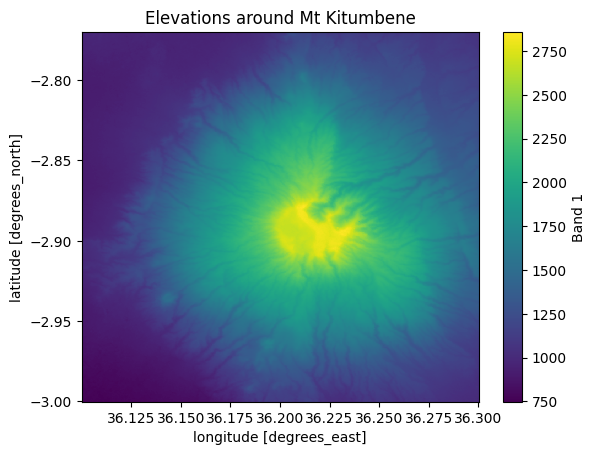

In [5]:
kitumbene["elevation"].plot()
plt.title("Elevations around Mt Kitumbene");

_**Figure 7.12.** Elevations in the area that was clipped based on a polygon._

After clipping, it is possible to continue working with the clipped `Dataset` and e.g. find the mean elevation for this area around the Mt Kitumbene. Notice that the operations clipped all the variables in our `Dataset` simultaneously. We can extract basic statistics from `elevation` and inspect the relative height in this area as follows:

In [6]:
# Mean elevation
kitumbene["elevation"].mean().item()

1467.7473111245304

In [7]:
# Update the relative height considering the minimum elevation on this area
kitumbene["relative_height"] = kitumbene["elevation"] - kitumbene["elevation"].min()

# Mean of the relative height
kitumbene["relative_height"].max().item()

2109.0

We can see that the mean elevation in this area is approximately 1470 meters while the maximum relative height is ~2100 meters. We needed to recalculate the relative height because the baseline minimum elevation in the landscape changed significantly after the clipping operation.

## Masking a raster

Another commonly used approach when working with raster data is to mask the data based on certain criteria or using another geographical layer as a mask. One common reasons for doing this is for example to exclude water bodies (e.g. lakes or oceans) from the terrain when doing specific analyses. In the following, we will continue working with the same elevation data and mask out the lakes from our raster dataset that exist in our study area. 

Let's start by downloading data from OpenStreetMap (OSM) about existing lakes in our study area. To do this, we first extract the bounds of our raster `Dataset` and then use `osmnx` library to fetch all OSM elements that have been tagged with key `"water"` and `"lake"` (read more about `osmnx` from Chapter 9.1):

/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/osmnx/features.py:678: PerformanceWarning: indexing past lexsort depth may impact performance.
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


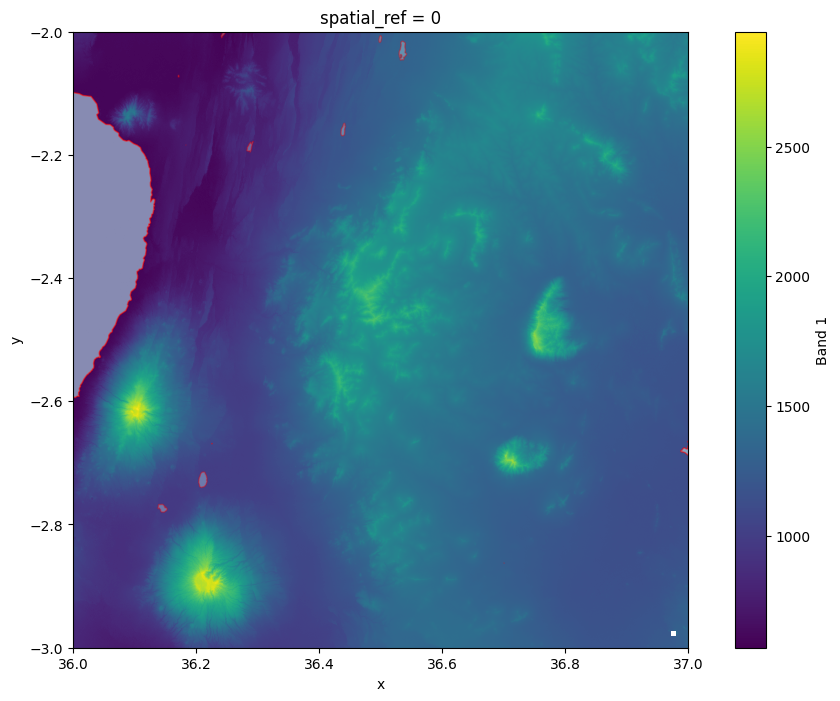

In [8]:
import osmnx as ox

# Extract the bounding box based on the extent of the raster
data_bounds_geom = box(*data["elevation"].rio.bounds())

# Retrieve lakes from the given area
lakes = ox.features_from_polygon(data_bounds_geom, tags={"water": ["lake"]})

# Plot the raster and lakes on top of each other
fig, ax = plt.subplots(figsize=(12, 8))
data["elevation"].plot(ax=ax)
lakes.plot(ax=ax, facecolor="lightblue", edgecolor="red", alpha=0.4);

_**Figure 7.13.** Existing lakes that are present in our study area._

As we can see from the Figure 7.10, there is one large lake and multiple smaller ones in our study that we might not want to be taken into account when analyzing the terrain. Luckily, we can easily mask these areas out of our `Dataset` by using `rioxarray`. To do this, we can use the same `.rio.clip()` method which we used in the previous example. However, in this case, we do not want to totally remove those cells from our `Dataset` but only mask them out, so that the values on those areas are replaced with NaN values. By using parameters `drop=False` and `invert=True`, the cells that are intersecting with the lake geometries will be masked with NaNs: 

In [9]:
masked_data = data.rio.clip(geometries=lakes.geometry, 
                            drop=False,
                            invert=True,
                            crs=data.elevation.rio.crs, 
                           )

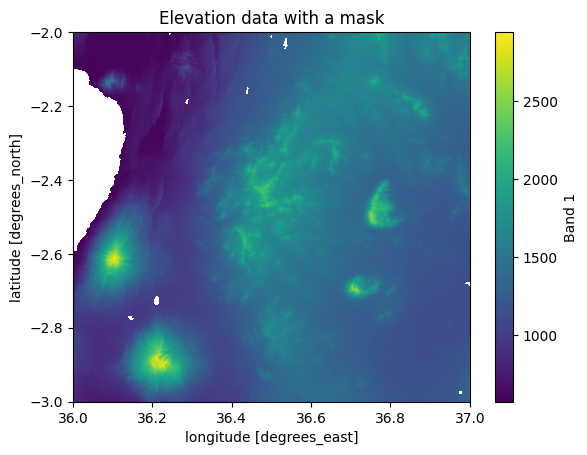

In [10]:
masked_data["elevation"].plot()
plt.title("Elevation data with a mask");

_**Figure 7.14.** A Dataset where the lakes have been masked out (shown with white color)._

As a result, we now have a new `Dataset` where the elevation values overlapping with the lakes have been converted to NaNs. We can now compare whether e.g. the mean land surface elevation differs from the original one where the lakes were still included:

In [11]:
print("Mean elevation with lakes:", data["elevation"].mean().round().item())
print("Mean elevation without lakes:", masked_data["elevation"].mean().round().item())

Mean elevation with lakes: 1258.0
Mean elevation without lakes: 1287.0


Based on this comparison, we can see that masking out the lakes increases the mean elevation in the area by approximately 30 meters. In a similar manner, you can mask any `rioxarray.Dataset` with given mask features that you want to remove from the analysis. 

## Creating a raster mosaic by merging datasets

One very common operation when working with raster data is to combine multiple individual raster layers (also called as tiles) into a single larger raster dataset, often called as raster mosaic. This can be done easily with the `merge_datasets()` -function in `rioxarray`.
Here, we will create a mosaic based on DEM files (altogether 4 files) covering Kilimanjaro region in Tanzania. First we will read elevation data from an S3 bucket. Let's start by creating a list of URL paths to given `GeoTiff` files that we have

In [12]:
import xarray as xr
from pathlib import Path
import rioxarray

# S3 bucket containing the data
bucket = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"
path = Path(bucket)

# Generate urls for the elevation files
urls = [
    path / "elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif",
    path / "elevation/kilimanjaro/ASTGTMV003_S03E037_dem.tif",
    path / "elevation/kilimanjaro/ASTGTMV003_S04E036_dem.tif",
    path / "elevation/kilimanjaro/ASTGTMV003_S04E037_dem.tif",
]

# Show the first path
urls[0]

PosixPath('https:/a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS/elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif')

Now we have a list of URL paths to the files that we want to read into `xarray`. To do this, we create a nested loop where we iterate over the `urls` list one `url` at a time and read the `GeoTiff` file using the `.open_dataset()` function as we introduced in Chapter 7.2:

In [13]:
datasets = [xr.open_dataset(url, engine="rasterio", masked=True, band_as_variable=True) for url in urls]

Now we have stored all the `xarray.Dataset` layers inside the list `datasets`. We can investigate the contents of the first `Dataset` in our list as follows:

In [14]:
datasets[0]

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_1       (y, x) float32 52MB ...
Attributes:
    Band_1:         Band 1
    AREA_OR_POINT:  Area

In [15]:
datasets[0].rio.shape

(3601, 3601)

As we can see an individual `Dataset` has a shape with 3601 cells on each dimension (x and y) and the name of the data variable `band_1` which represents the elevation values. Let's visualize these four raster tiles in separate maps to see how they look like. To do this, we use `plt.subplots()` to initialize a figure with 2x2 subplots and then visualize the rasters one by one. We use `vmax` parameter to specify a same value scale for each layer that makes the colors in the map comparable:

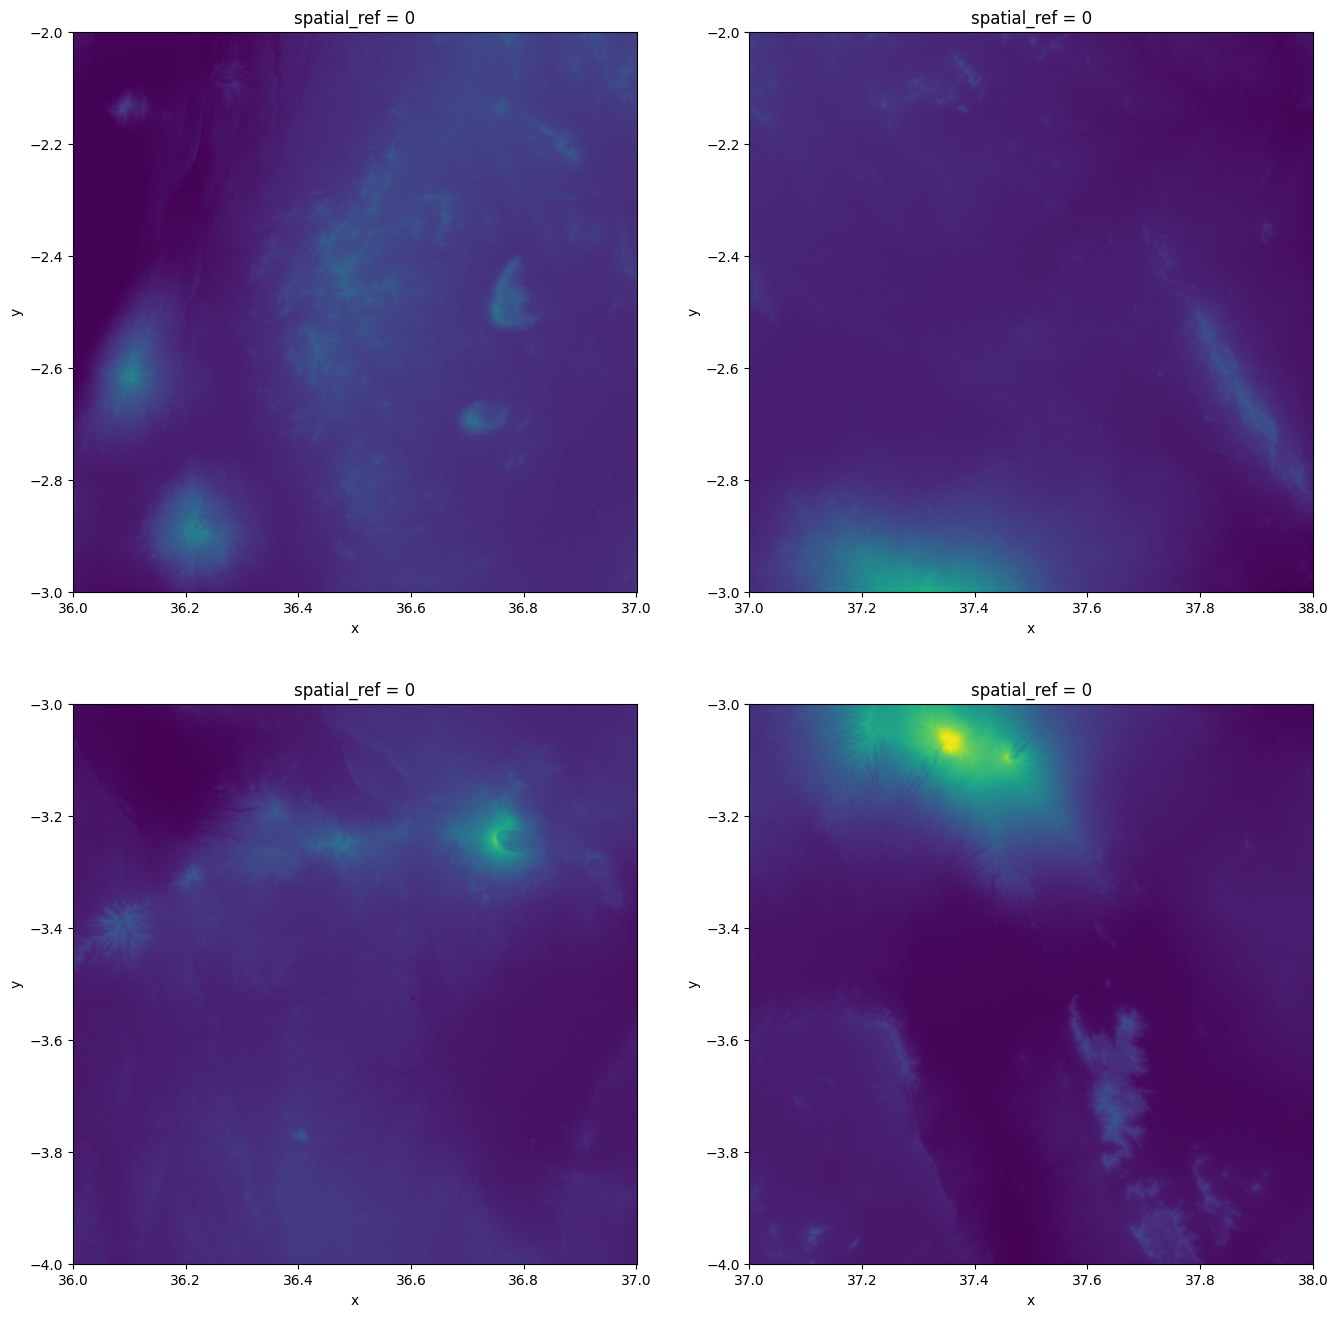

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot the tiles to see how they look separately
datasets[0]["band_1"].plot(ax=axes[0][0], vmax=5900, add_colorbar=False)
datasets[1]["band_1"].plot(ax=axes[0][1], vmax=5900, add_colorbar=False)
datasets[2]["band_1"].plot(ax=axes[1][0], vmax=5900, add_colorbar=False)
datasets[3]["band_1"].plot(ax=axes[1][1], vmax=5900, add_colorbar=False);

_**Figure 7.15.** Four elevation raster layers plotted next to each other._

From the figure we can see that these four raster tiles seem to belong together naturally as the elevation values as well as the coordinates along the x- and y-axis continue smoothly. Hence, we can stitch them together into a single larger raster `Dataset`.
To merge multiple `xarray.Dataset`s together, we can use the `.merge_datasets()` function from `rioxarray`:

In [17]:
from rioxarray.merge import merge_datasets

mosaic = merge_datasets(datasets)
mosaic

/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)


<xarray.Dataset> Size: 208MB
Dimensions:      (x: 7201, y: 7201)
Coordinates:
  * x            (x) float64 58kB 36.0 36.0 36.0 36.0 ... 38.0 38.0 38.0 38.0
  * y            (y) float64 58kB -2.0 -2.0 -2.001 -2.001 ... -3.999 -4.0 -4.0
    spatial_ref  int64 8B 0
Data variables:
    band_1       (y, x) float32 207MB 826.0 826.0 823.0 ... 832.0 838.0 844.0
Attributes:
    Band_1:         Band 1
    AREA_OR_POINT:  Area

Excellent! Now we have successfully merged the individual datasets together which is evident from the shape of the new `Dataset` that has 7201 cells on x and y axis. Let's now rename our data variable to a more intuitive one and plot the result to see how the end result looks like:

In [18]:
mosaic = mosaic.rename({"band_1": "elevation"})

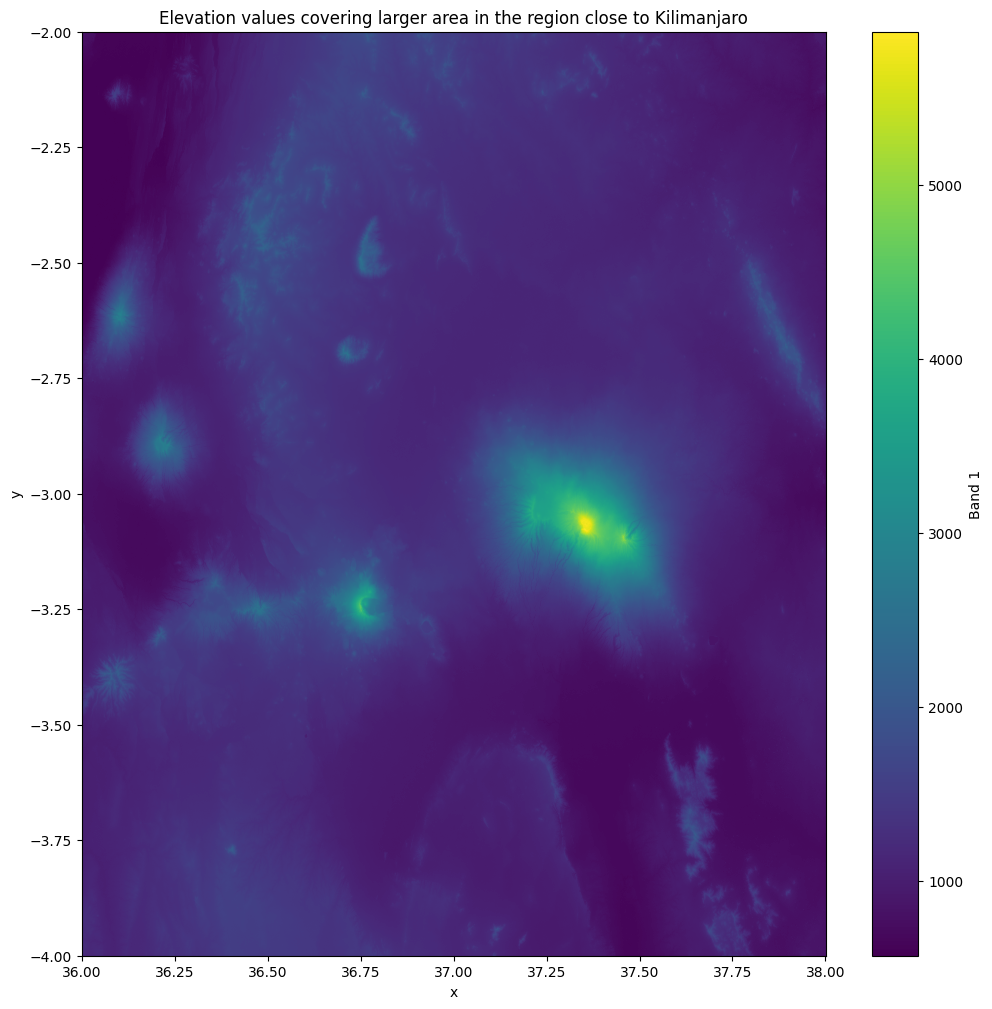

In [19]:
mosaic["elevation"].plot(figsize=(12, 12))
plt.title("Elevation values covering larger area in the region close to Kilimanjaro");

_**Figure 7.16.** A raster mosaic where four raster tiles were merged together._

The end result looks good and we can see clearly the Mount Kilimanjaro which is the highest mountain in Africa 5895 meters above sea level and the highest volcano in the Eastern Hemisphere. 

## Raster to vector conversion (vectorize)

Another commonly used technique commonly needed when working with geographic data is to convert the data from raster to vector format and vice versa. These conversion techniques are commonly called as `vectorize` or `rasterize` operations. When we convert a raster `Dataset` to vector format the raster cells are converted into `shapely.Polygon` objects and the values of the cells are stored as an attribute (column) in the resulting `GeoDataFrame`. To convert `xarray.DataArray` into vector format, you can use the `geocube` library that helps doing these kind of data conversions. In the following, we continue work with the `kitumbene` elevation data that we created earlier by clipping the data and convert this layer into vector format. Let's have a quick look on our input `DataArray` before continuing:

In [20]:
kitumbene["elevation"]

<xarray.DataArray 'elevation' (y: 828, x: 720)> Size: 5MB
array([[ 979.,  985.,  988., ..., 1056., 1054., 1054.],
       [ 978.,  982.,  983., ..., 1054., 1055., 1057.],
       [ 975.,  975.,  977., ..., 1058., 1058., 1059.],
       ...,
       [ 749.,  753.,  752., ..., 1003., 1003., 1003.],
       [ 753.,  753.,  752., ...,  999., 1001., 1002.],
       [ 755.,  754.,  751., ...,  999., 1000., 1000.]])
Coordinates:
  * x            (x) float64 6kB 36.1 36.1 36.1 36.1 ... 36.3 36.3 36.3 36.3
  * y            (y) float64 7kB -2.77 -2.771 -2.771 -2.771 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B 0
Attributes:
    Band_1:         Band 1
    long_name:      Band 1
    AREA_OR_POINT:  Area

To vectorize a given variable in your `xarray.Dataset`, you can use the `vectorize` function from the `geocube` library as follows:

In [21]:
from geocube.vector import vectorize

gdf = vectorize(kitumbene["elevation"].astype("float32"))
gdf.shape

(500279, 2)

In [22]:
gdf.head()

,elevation,geometry
0,979.0,"POLYGON ((36.10014 -2.77014, 36.10014 -2.77042..."
1,985.0,"POLYGON ((36.10042 -2.77014, 36.10042 -2.77042..."
2,988.0,"POLYGON ((36.10069 -2.77014, 36.10069 -2.77042..."
3,987.0,"POLYGON ((36.10125 -2.77014, 36.10125 -2.77042..."
4,984.0,"POLYGON ((36.10153 -2.77014, 36.10153 -2.77042..."


Great! Now we have converted the `DataArray` into vector format and as a result we got a `GeoDataFrame` that contains the geometries of individual cells as `shapely.Polygon` objects in the `geometry` column, and the cell values in the column `elevation`. The name of the column will be automatically added based on the name of the `DataArray`. As we can see from the `gdf.shape` all the raster cells were added as individual rows into the `GeoDataFrame` which means that our 2D array with 828 rows and 728 columns result in approximately 500 thousand rows in the `GeoDataFrame`. 

When working with surface data (e.g. elevation), it is quite common that there are similar values close to each other in the raster cells and often there are specific regions where the elevation does not change. Therefore, after the vectorization operation it is a good idea to dissolve the geometries based on the data attribute which merges geometries with identical values into single geometries instead of representing all the values as separate polygons. To do this, we can use the `.dissolve()` function which we introduced in more detail in Chapter 6.3:


In [23]:
gdf = gdf.dissolve(by="elevation", as_index=False)
gdf.shape

(2110, 2)

As we can see, the number of rows in our `GeoDataFrame` was reduced dramatically from more than 500 thousand rows into a bit over 2000 rows. Let's finally plot our `GeoDataFrame` to see how the data looks like:

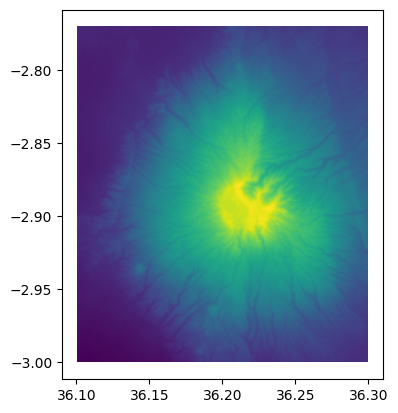

In [24]:
gdf.plot(column="elevation");

_**Figure 7.17.** The elevation map made from the vectorized data._

As we can see from the figure, the map looks identical to our original `DataArray` (Figure 7.9) which means that the conversion works as it should. 

It is good to keep in mind that the raster data structure (i.e. arrays) is much more efficient way to process continuous surfaces. When every cell in the 2D array is converted into polygon geometries, the processing and visualization of the data typically becomes more resource intensive for the computer (making things slower). There are approaches to deal with this issue e.g. by categorizing the data values of the surface into specific elevation classes (e.g. with 5 meter intervals) and then dissolving the geometries into larger Polygon shapes (as we did earlier without categorization). Another technique to consider is downscaling your data into lower resolution, meaning that the size of an individual cell will be larger. Naturally, both of these techniques has an impact on the quality of the data as the data is generalized and aggregated. It is a good idea to do the preprocessing steps for the raster data before vectorizing it, especially if you have large raster arrays because the array operations in `xarray` are very efficient. 

## Vector to raster conversion (rasterize)

Now as we have seen how to convert the data from raster to vector, let's continue and see how to do the conversion from vector to raster data format, i.e. how to rasterize a vector dataset. In this example, we aim to rasterize the lakes that we downloaded earlier from OpenStreetMap. Let's have a look how the data looks like:

/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/osmnx/features.py:678: PerformanceWarning: indexing past lexsort depth may impact performance.
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


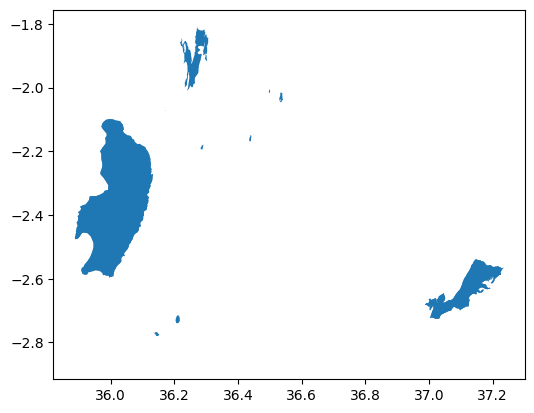

In [25]:
lakes = ox.features_from_polygon(data_bounds_geom, tags={"water": ["lake"]})

lakes.plot();

_**Figure 7.18.** Lakes represented in vector format._

In [26]:
lakes.shape

(16, 15)

In [27]:
lakes.tail(2)

,,geometry,natural,water,name,name:de,name:es,name:fr,name:it,name:pt,name:sk,wikidata,wikipedia,intermittent,salt,type
element,id,,,,,,,,,,,,,,,
way,1355142947,"POLYGON ((36.7008 -2.86243, 36.70067 -2.86243,...",water,lake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relation,2315592,"POLYGON ((36.22203 -1.85475, 36.22273 -1.85303...",water,lake,Lake Magadi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon


As we can see the `lakes` `GeoDataFrame` contains polygons and have various attributes associated with them, although majority of these attributes do not contain any relevant data. Thus, let's just pick a few columns that are most interesting to us:

In [28]:
lakes = lakes[["geometry", "water", "name"]].copy().reset_index()
lakes.shape

(16, 5)

Our `GeoDataFrame` does not currently really include any useful numerical data (except `id`) that we would perhaps want to store as an attribute into our raster `DataArray`. Thus, let's create one numerical attribute into our data and calculate the area of the lakes as something we will use as values in our raster. We can use some of the vector data processing tricks to do this which were introduced in Chapter 6:

In [29]:
# Reproject to metric system
lakes_utm = lakes.to_crs(epsg=21037)

# Calculate the area in km2
lakes_utm["area_km2"] = lakes_utm.area / 1000000

# Join the area information with the original gdf
lakes = lakes.join(lakes_utm[["area_km2"]])

In [30]:
lakes.head(5)

,element,id,geometry,water,name,area_km2
0,way,698412673,"POLYGON ((36.22572 -2.66849, 36.22584 -2.6685,...",lake,NaN,0.001602
1,way,724099461,"POLYGON ((36.1394 -2.76761, 36.13989 -2.76752,...",lake,NaN,1.435812
2,way,724099746,"POLYGON ((36.20467 -2.7295, 36.20459 -2.72856,...",lake,NaN,3.120696
3,way,23786069,"POLYGON ((35.91633 -2.5593, 35.9193 -2.55463, ...",lake,Lake Natron,819.954659
4,way,23786069,"POLYGON ((35.91633 -2.5593, 35.9193 -2.55463, ...",lake,Lake Natron,819.954659


In the previous, we first reprojected the data into EPSG:21037 (Arc 1960 / UTM zone 37S) which is a UTM (Universal Transverse Mercator) projection that covers most of Tanzania and provides accurate distance and area calculations. Then we calculated the area of the lakes into square kilometers and finally joined the information about the area into our original `GeoDataFrame`that is in WGS84 coordinate reference system. 

By looking at the resulting table we can see something interesting. It appears that the `lakes` data contain some duplicate rows as the `Lake Natron` is present twice in our table (something to do with fetching data from OSM). This can cause issues when rasterizing the data because there should not be geometries that overlap with each other. Thus, we want to remove all duplicate rows from the data before continuing:

In [31]:
lakes = lakes.drop_duplicates()
lakes.shape

(14, 6)

As a result, two duplicates were dropped from the `GeoDataFrame`. Now we are ready to rasterize our `GeoDataFrame` into `xarray`. To do this, we can use the `make_geocube()` function from the `geocube` library:

In [32]:
from geocube.api.core import make_geocube

lakes_ds = make_geocube(vector_data=lakes,
                        measurements=["id", "area_km2"],
                        resolution=(-0.01, 0.01),
                        output_crs="epsg:4326"
                       )
lakes_ds

<xarray.Dataset> Size: 235kB
Dimensions:      (y: 107, x: 136)
Coordinates:
  * y            (y) float64 856B -1.805 -1.815 -1.825 ... -2.845 -2.855 -2.865
  * x            (x) float64 1kB 35.89 35.9 35.91 35.92 ... 37.22 37.23 37.24
    spatial_ref  int64 8B 0
Data variables:
    id           (y, x) float64 116kB nan nan nan nan nan ... nan nan nan nan
    area_km2     (y, x) float64 116kB nan nan nan nan nan ... nan nan nan nan

As a result, we now have an `xarray.Dataset` with two data variables. In the code above, we specified that the `lakes` `GeoDataFrame` is used as the input `vector_data` and the columns `id` and `area_km2` should be included as the `measurements`, i.e. the data that are stored into separate `xarray` variables. The `resolution` parameter defines the spatial resolution of the output grid, i.e. size of a single pixel in the raster. In our case, we specified a tuple with values `(-0.01, 0.01)` that are presented as decimal degrees because the coordinate reference system of our input data is WGS84. Thus, resolution `0.01` indicates that the size of a single pixel in our raster is approximately 1x1 kilometers (1.11km). The negative sign for x-resolution is used because raster transformations often use negative values for the y-axis in many CRS systems, where the y-coordinates decrease as you move down the raster. Finally, the `output_crs` defines the CRS for the resulting `Dataset`. Let's make a map out of our data to see how the result looks like:

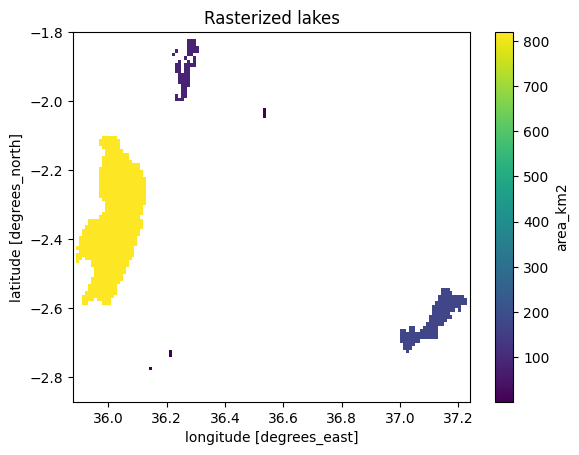

In [33]:
lakes_ds["area_km2"].plot()
plt.title("Rasterized lakes");

_**Figure 7.19.** Lakes that have been rasterized into `DataArray` at approximately 1 km resolution._

Quite often when rasterizing vector data, you actually want to fit the output to have identical resolution to an already existing `xarray.Dataset` and align it with the other raster layer. For example in our case, we can use the `data` raster (with elevation values) as a target so that the resolution, dimensions and alignment would fit with the existing `Dataset`. We can achieve this by using the `like` parameter in `make_geocube()` function. This will ensure that the output aligns with the existing raster having same resolution and dimensions:

In [34]:
aligned_ds = make_geocube(vector_data=lakes,
                          measurements=["id", "area_km2"],
                          like=data)
aligned_ds

<xarray.Dataset> Size: 208MB
Dimensions:      (y: 3601, x: 3601)
Coordinates:
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
    spatial_ref  int64 8B 0
Data variables:
    id           (y, x) float64 104MB nan nan nan nan nan ... nan nan nan nan
    area_km2     (y, x) float64 104MB nan nan nan nan nan ... nan nan nan nan

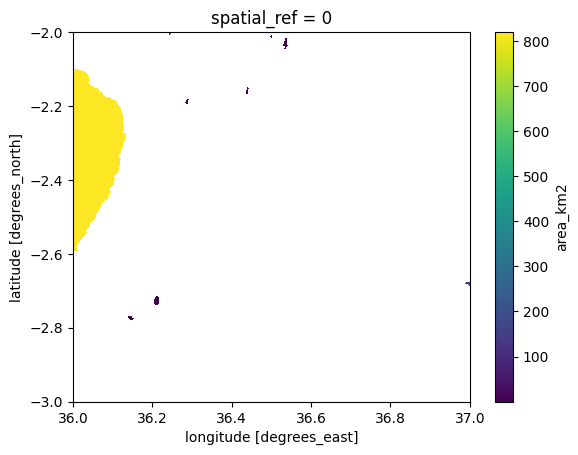

In [35]:
aligned_ds["area_km2"].plot();

_**Figure 7.20.** Lakes that have been rasterized and aligned with an existing `Dataset`._

As a result, we have now rasterized the lakes in a way that the `aligned_ds` aligns with the existing `Dataset` containing the elevation values. This technique can be very useful especially when you want to do calculations (map algebra) between multiple raster layers (more about map algebra in Chapter 7.5). 

## Resampling raster data

In the following section, we will introduce a technique that allows you to resample your raster data. Resampling refers to changing the cell values due to changes in the raster grid for example due to changing the effective cell size of an existing dataset. There are two ways to resample your raster data. Upscaling (or upsampling) refers to cases in which convert the raster to higher resolution, i.e. smaller cells. Downscaling (or downsampling) is resampling to lower resolution, i.e. having larger cell sizes. In the following, we will see how we can resample an `xarray.Dataset` by downscaling and upscaling the data. 

We can resample `xarray` data by using the `rioxarray` library that can be used to downscale and upscale raster data. Whenever downscaling data, you are ultimately aggregating the information because multiple individual cells are merged into one larger cell that is then stored in the output grid. Thus, it is important to decide the `resampling` method which determines how the data values are aggregated. Depending on the input data, you might for example calculate the `average` of the input cells which will then be stored in the output grid cell. In our case, taking the average makes sense, because our input data represents elevation. However, in some cases you might be interested to `sum` all the cell values for example if your input data would represent population counts in a given region. There are also various other ways to resample the data, such as extracting the minimum (`min`), maximum (`max`), median (`med`) or the `mode` from the input cells. The `mode` means that the value which appears most often in the input raster cells is selected to the output raster cell.  

### Downscaling

In the following, we will downscale our elevation data significantly by using a downscale factor of `50`. This means that the output raster will be 50 times smaller in terms of its dimensions compared to the input raster. To downscale the data, you need to define the new `shape` for our target raster `Dataset`. Here, we use a specific `downscale_factor` that is used to calculate the new width and height for the output `Dataset`. The width and height for the target `Dataset` need to be provided as integer values. Thus we ensure that the dimensions are integers by rounding (`round()`) and converting the number with`int()`. The `.rio.reproject()` method is then used to downscale the data using the new `shape`. The `resampling` parameter defines the resampling method which in our case will be `Resampling.average`. The `Resampling` class from `rasterio` library provides the methods for resampling:

In [36]:
from rasterio.enums import Resampling

# Define the new shape
downscale_factor = 50
new_width = int(round(data.rio.width / downscale_factor))
new_height = int(round(data.rio.height / downscale_factor))

# Downscale the data
data_downscaled = data.rio.reproject(
    dst_crs=data.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.average,
)

In [37]:
data_downscaled

<xarray.Dataset> Size: 63kB
Dimensions:          (x: 72, y: 72)
Coordinates:
  * x                (x) float64 576B 36.01 36.02 36.03 ... 36.97 36.98 36.99
  * y                (y) float64 576B -2.007 -2.021 -2.035 ... -2.979 -2.993
    spatial_ref      int64 8B 0
Data variables:
    elevation        (y, x) float64 41kB 810.4 801.3 ... 1.251e+03 1.286e+03
    relative_height  (y, x) float32 21kB 242.4 233.3 162.9 ... 663.7 683.2 718.4

As we can see, now the dimensions of the new downscaled `Dataset` is 72x72 cells on x and y axis which is 50 times smaller compared to the original `data` that we used as input:

In [38]:
data.rio.shape

(3601, 3601)

In [39]:
print("Original resolution:", data.rio.resolution())
print("Downscaled resolution:", data_downscaled.rio.resolution())

Original resolution: (0.0002777777777777778, -0.0002777777777777781)
Downscaled resolution: (0.013892746913580308, -0.013892746913580263)


By comparing the spatial resolution between the datasets, we can see that the new resolution of the downscaled `Dataset` is slightly over 1x1 km (~0.014 decimal degrees). Let's finally visualize the downscaled `Dataset` to investigate how the result looks on a map:

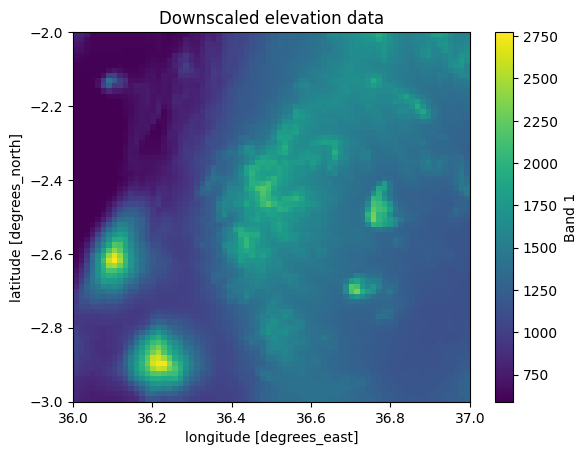

In [40]:
data_downscaled["elevation"].plot()
plt.title("Downscaled elevation data");

_**Figure 7.21.** Downscaled data using a downscale factor of 50._

The downscaling operation seem to have worked well as the patterns are still clearly similar compared to the input data (Figure 7.7), although the spatial resolution is much lower. The data is downscaled so much that it is actually possible to identify individual pixels of the grid. 

### Upscaling

The process of upscaling works very similarly to downscaling and we can use the same `rioxarray` method to increase the resolution of the input raster. In the following, we will specify that the new shape of the output `Dataset` will be two times larger than the input data. When upscaling, you are ultimately estimating values to new pixel cells based on the neighboring raster values of a given cell in the input raster. There are various ways to interpolate data which are provided in the Table 7.2. 


: _**Table 7.2**. Different resampling methods and their descriptions._

| Resampling Method    | Description                                                                                                               |
|:--------------------:|:-------------------------------------------------------------------------------------------------------------------------:|
| `nearest`            | Selects the value of the closest pixel without interpolation. Fast but can produce blocky artifacts.                      |
| `bilinear`           | Performs linear interpolation using the four nearest pixels, creating a smoother result than nearest-neighbor.            |
| `cubic`              | Uses bicubic interpolation, considering 16 surrounding pixels. Smoother output than bilinear. Higher computational cost.  |
| `cubic_spline`       | Applies cubic spline interpolation for even smoother results, but requires more processing power.                         |
| `lanczos`            | Uses a sinc-based interpolation over a larger pixel neighborhood, producing resampling with significant smoothing.        |
| `average`            | Average resampling, computes the weighted average of all non-NODATA contributing pixels.                                  |


In the following, we will take advantage of a `Resampling.bilinear` resampling method which determines the value of a new pixel by taking a weighted average of the four nearest input pixels:

In [41]:
from rasterio.enums import Resampling

# Define the new shape
upscale_factor = 2
new_width = data.rio.width * upscale_factor
new_height = data.rio.height * upscale_factor

# Upscale the data
data_upscaled = data.rio.reproject(
    data.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

Now we have successfully upscaled our data which we can confirm by comparing the shapes of the original and upscaled datasets:

In [42]:
print("Shape - Original:", data.rio.shape)
print("Shape - Upscaled:", data_upscaled.rio.shape)

Shape - Original: (3601, 3601)
Shape - Upscaled: (7202, 7202)


As expected, the new `data_upscaled` raster contains twice as many pixels compared to the input which is exactly what we were after. In a similar manner, you can upscale the data into different resolutions by providing a given target `shape` to your new raster layer. Notice that there is no "correct” way to do upscaling as all resampling methods involve interpolation that introduces uncertainty to the results. Let's finally confirm that our upscaled data looks correct also on a map:

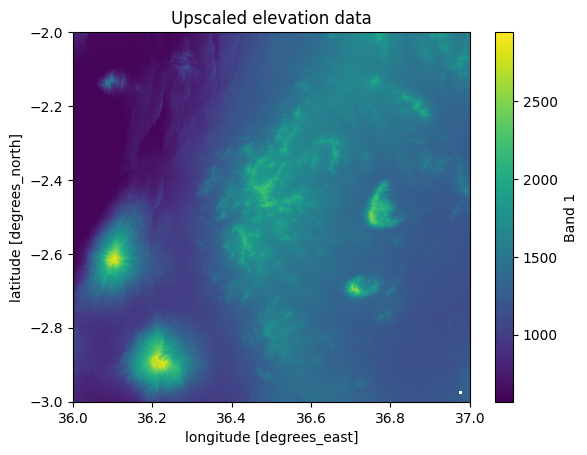

In [43]:
data_upscaled["elevation"].plot();
plt.title("Upscaled elevation data");

_**Figure 7.22.** Upscaled data using a upscale factor of 2._

## Handling missing data

To be added. 